#Team Members: Rahul Krishnamoorthy, Neil Arakkal 

#1. Load the Input Image



Image height:  416  width:  600


<Figure size 864x864 with 0 Axes>

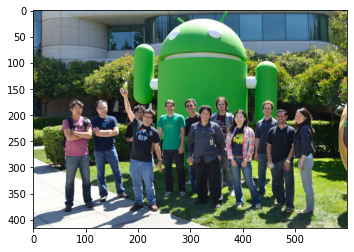

In [ ]:
from PIL import Image
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import math
import cv2
from scipy import signal

img_url = 'https://drive.google.com/uc?export=view&id=11ckrrCVnKq8oD0ATWRddwfR0308r3bpw'
#img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img = Image.open(urlopen(img_url))

# Show the image size.
print('Image height: ', img.height,' width: ',img.width)

# Plot the image.
def display_image(img):
  plt.figure(figsize=(12,12))
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  
display_image(img)

#1.1. Enhancing brightness of the image

For brightening the image, we simply multiply the value for each pixel in all the channels by 2. The image is loaded as a 32-bit int instead of uint8 so that the values can flow over 255. We then check if the value has exceeded 255 and then set it back to 255.

<Figure size 864x864 with 0 Axes>

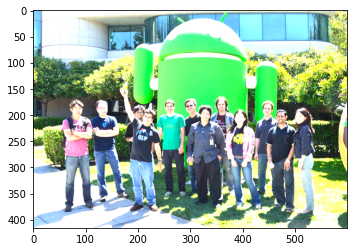

In [ ]:
arr = np.array(img, dtype=np.int32)
arr = arr*2
arr[arr>255] = 255
display_image(arr)

#1.2. Vignette Effect
The vignette filter is supposed to create an image that is brighter near the center of the image and as we move away from the center, the image has to become darker. A Gaussian filter fits this specification where the values slowly decrease when we move away from the center. Thus, a Gaussian filter that has the same size as the input image can be multiplied element-wise to get the desired result. We observed that it takes a lot of time to create a gaussian filter which is the same size as the image. So we created two Gaussian filters, both of them being one dimensional, one which has the same size as the number of rows of the image and the other being the same size as that of the number of columns of the image. Since a product of two gaussian filters give another Gaussian filter, and a product of two vectors of the size, r x 1 and 1 x c gives a filter of size r x c, these two Gaussian filters can be multiplied to get a Gaussian filter with the same size as the image. An element-wise multiplication of this kernel with all the channels of the image gives the desired output. The implementation is not entirely real time now. But this can be done if the 2 gaussians vectors can be convolved one after the another instead of creating a huge gaussian kernel which is the same size of the image and then convolving this kernel over the input image. One can control the intensity of this effect by altering the value of sigma when creating the Gaussian filters.

416 600


<Figure size 864x864 with 0 Axes>

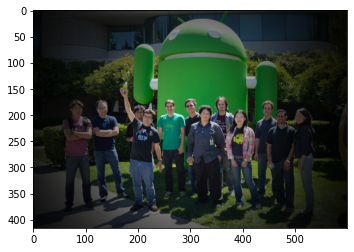

In [ ]:
arr = np.array(img)
r,c,_ = arr.shape
print(r,c)
def create_gaussian(size, mean, sigma):
  linear = np.linspace((-(size-1)/2), ((size-1)/2), size)
  kernel = np.zeros((size))
  for i in range(len(linear)):
    kernel[i] = math.exp(-(linear[i]**2)/(2*(sigma**2)))
  kernel = kernel/(2*math.pi*(sigma**2))
  return kernel
gaussian1 = create_gaussian(r,0,150)
gaussian1 = np.reshape(gaussian1, (r,1))
gaussian2 = create_gaussian(c,0,150)
gaussian2 = np.transpose(gaussian2)[np.newaxis]
vignette_image = np.zeros_like(arr)
mask = gaussian1.dot(gaussian2)
mask = np.reshape(mask, (r,c))
mask = mask/np.max(mask)
for i in range(vignette_image.shape[2]):
  vignette_image[:,:,i] = arr[:,:,i]*mask
display_image(vignette_image)

#2. Loading the Grayscale image

<Figure size 864x864 with 0 Axes>

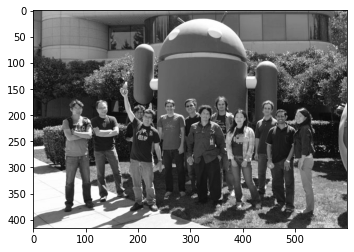

In [ ]:
# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/images/google_android.jpg'
img = Image.open(urlopen(img_url))
img = np.array(img)

# Converting image to grayscale.
img = img.astype('float')
img = (img[:, :, 0] + img[:, :, 1] + img[:, :, 2]) / 3.0

# Plot the image.
def display_image(img):
  plt.figure(figsize=(12,12))
  plt.figure()
  plt.gray()
  plt.imshow(img)
  plt.grid(False)
  plt.show()

display_image(img)

#2.1. Gaussian Blur

In order to achieve the gaussian blur, we start by creating a gaussian kernel. The gaussian kernel follows the symmetric gaussian distribution, i.e., $$G(x,y)=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$
The size chosen for the kernel, was 15x15 with $\sigma = 0.8$. Creating the kernel is is a one-time process and the same kernel can be applied to different images. The kernel is then convoluted with the image to apply the gaussian blur filter. 
<br><br><br>
A larger $\sigma$ value makes the image more blurrier. $\sigma$ represents the standard deviation from the center for each value in the gaussian filter, therefore more weight is given to neighboring pixels.

<Figure size 864x864 with 0 Axes>

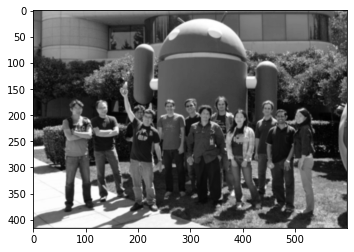

In [ ]:
def create_gaussian(size, mean, sigma):
  linear = np.linspace((-(size-1)/2), ((size-1)/2), size)
  kernel = np.zeros((size,size))
  for i in range(len(linear)):
    for j in range(len(linear)):
      kernel[i,j] = math.exp(-((linear[i]**2) + (linear[j]**2))/(2*(sigma**2)))
  kernel = kernel/(2*math.pi*(sigma**2))
  return kernel
kernel = create_gaussian(15,0,0.8)
arr = np.array(img)
blurred_image = signal.convolve2d(arr, kernel, mode='same')
display_image(blurred_image)

#2.2. Bilateral Filter
A bilateral filter computes the squared distance between the intensity values between the selected pixel value with all other pixels within the given kernel and applies it to the gaussian formula. It wasn’t possible to implement a kernel that would move across the image and compute the squared distances between the intensity values. So we implemented an algorithm that would iterate through all the pixels in the image and for each pixel, the algorithm would iterate through all the pixels within the kernel for that pixel and compute the value using the formula provided in the problem. We can see that a beta value of 15 has a perfect balance between how bright the image is and how much blur is applied to the image.

<Figure size 864x864 with 0 Axes>

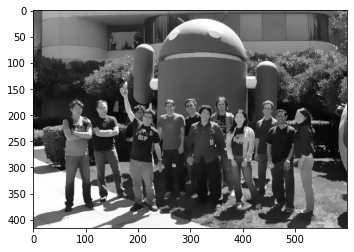

In [ ]:
arr = np.array(img)
def bilateral(kernel_size, img, beta):
  kernel = int((kernel_size - 1)/2)
  padded = np.pad(img,[(kernel,kernel),(kernel,kernel)],mode='constant') #pad the image on all four sides
  shape = padded.shape
  filtered = np.zeros_like(img)
  total = 0
  sum2 = 0
  for i in range(kernel, shape[0]-(kernel)):
    total=0
    sum2 = 0
    for j in range(kernel, shape[1]-(kernel)):
      total=0
      sum2 = 0
      for k in range(i-kernel, i+kernel):
        for l in range(j-kernel, j+kernel):
          val = (math.exp(-(((padded[k,l] - padded[i,j])**2)/(2*(beta**2)))))
          sum2 = sum2 + val
          val = val*padded[k,l]
          total = total + val
      total = total / (2*sum2*math.pi*(beta**2))
      filtered[i-kernel,j-kernel] = total
      sum2 = 0
      total = 0
  return filtered
bi = bilateral(15, arr,15)
display_image(bi)

#2.3. Image Gradients
The magnitude map for the image can be created using the Sobel operators. We create the two Sobel operators in the x and y direction and then do two seperate convolutions with the source image twice. Using the two convolutions we can create the magnitude map by taking the magnitude for each pixel in the x and y convolutions.

<Figure size 864x864 with 0 Axes>

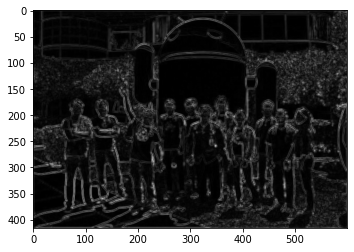

In [ ]:
arr = np.array(img)
magnitude_map = np.zeros((arr.shape))
def create_sobel():
  gy = np.zeros((3,3))
  x = np.array([1, 2, 1])
  gy[:,0] = -x
  gy[:,2] = x
  gx = np.transpose(gy)
  return gx, gy
gx, gy = create_sobel()
gx_con = signal.convolve2d(arr, gx, mode='same')
gx_con2 = signal.convolve2d(gx_con, gx, mode='same')
gy_con = signal.convolve2d(arr, gy, mode='same')
gy_con2 = signal.convolve2d(gy_con, gy, mode='same')
magnitude_map = (gx_con2**2 + gy_con2**2)**(0.5)
display_image(magnitude_map)

#2.4. Emphasizing Boundaries
Using the above magnitude map, the edges in the output image were highlighted. We set all the values in the magnitude map to be either 255 or 0 based on their intensity to create a binary mask. We then apply this to the original image, where the pixels that are set to 255 in the binary mask are changed to 0 (black).

<Figure size 864x864 with 0 Axes>

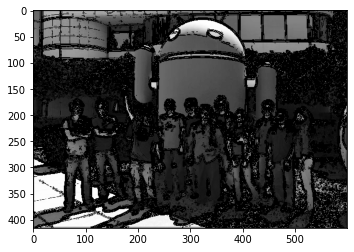

In [ ]:
magnitude_map[magnitude_map>255] = 255
magnitude_map[magnitude_map<255] = 0
output_image = np.array(img)
output_image[magnitude_map==255] = 0
display_image(output_image)

#3. Exact Histogram Equalization
The histogram of the input has to be switched to be entirely uniform as per the problem statement. For this purpose, 5 averaging kernels were created by convolving the kernels over the image which would find 5 averages over the input image and store it in a matrix after flattening them. The matrix is then sorted lexicographically. The new histogram to which the current histogram should be matched to is a uniform signal with the amplitude equal to the product of number of rows and columns divided by the number of bins it has to be assigned to. After sorting through the matrix lexicographically, each bin of the image is assigned with the corresponding pixels with the same size specified in the histogram (uniform signal). The last row of this matrix has the original pixel locations and when ‘argsort’ of this is performed, the new image can be obtained. 

Reference: https://github.com/StefanoD/ExactHistogramSpecification/blob/master/histogram_matching.py

The code here was referred to find how the matrix can be sorted lexicographically. The remaining parts of the code were programmed on our own.


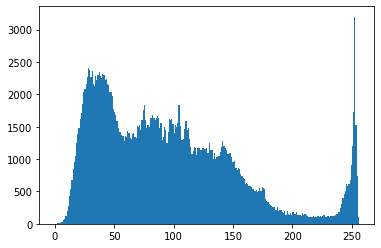

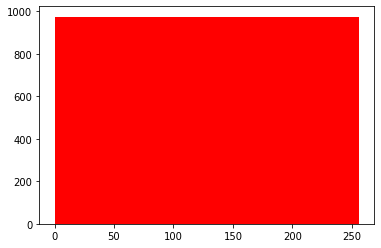

<Figure size 864x864 with 0 Axes>

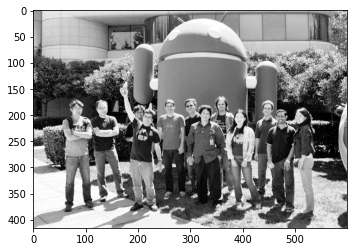

In [ ]:
def exactHistEq(im):
  arr = np.array(im)
  plt.figure()
  plt.hist(arr.flatten(), 256, [0,256])
  kernel1 = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]])/5
  kernel2 = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]])/9
  kernel3 = np.array([[0, 0, 1, 0, 0],[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[0, 1, 1, 1, 0],[0, 0, 1, 0, 0]])/13
  kernel4 = np.array([[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[0, 1, 1, 1, 0]])/21
  kernel5 = np.array([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]])/25
  avg1 = signal.convolve2d(im, kernel1, 'same')
  avg2 = signal.convolve2d(im, kernel2, 'same')
  avg3 = signal.convolve2d(im, kernel3, 'same')
  avg4 = signal.convolve2d(im, kernel4, 'same')
  avg5 = signal.convolve2d(im, kernel5, 'same')
  ktuples = np.zeros((arr.shape[0]*arr.shape[1], 7))
  ktuples[:,0] = arr.flatten()
  ktuples[:,1] = avg1.flatten() 
  ktuples[:,2] = avg2.flatten() 
  ktuples[:,3] = avg3.flatten() 
  ktuples[:,4] = avg4.flatten() 
  ktuples[:,5] = avg5.flatten() 
  ktuples[:,6] = np.array([i for i in range(arr.shape[0]*arr.shape[1])]).transpose()
  temp = np.rot90(ktuples)
  sort = np.lexsort(temp)
  sorted_ktuples = ktuples[sort]
  histogram, bins = np.histogram(arr.flatten(), bins = 256, range = [0, 256])
  uniform = np.ones_like(histogram) * int(((arr.shape[0]*arr.shape[1])/256))
  x = 0
  for i in range(0, 256):
    sorted_ktuples[x:x+uniform[i], 0] = i
    x = x+uniform[i]
  ind = np.argsort(sorted_ktuples[:,-1])
  sorted_ktuples = sorted_ktuples[ind]
  new_target_img = sorted_ktuples[:, 0].reshape(arr.shape)
  plt.figure()
  plt.hist(new_target_img.flatten(),256,[0,256], color = 'r')
  display_image(new_target_img)
  return new_target_img

new_img = exactHistEq(img)

#4. Color Segmentation
The color segmentation of the image has to be performed without having any illumination variance and has to perform even if the surface has some deforms. The image was blurred using a very huge gaussian kernel which has a high sigma value. This was done so that none of the image’s deformity can affect the color segmentation. It is also done so that the neighboring pixels resemble the current pixel so that we can remove some of the illumination variances in the image. Once the image is blurred, the yellow component of the image is found out from the input RGB image. Various ranges were tried out and the particular range for the yellow channel is able to segment the image properly.

<Figure size 864x864 with 0 Axes>

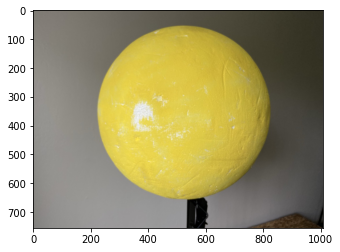

<Figure size 864x864 with 0 Axes>

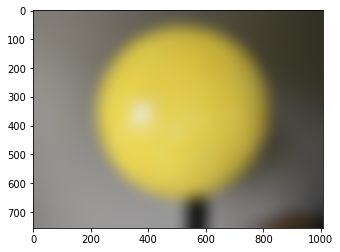

<Figure size 864x864 with 0 Axes>

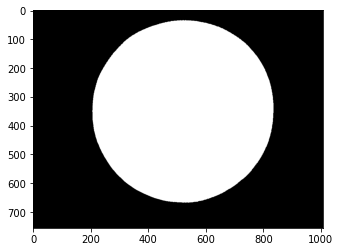

In [ ]:
img_url = 'https://drive.google.com/uc?export=view&id=1vYWpzSzUuoCyC6SeNYjmd8ew3SaLeKDY'
im = Image.open(urlopen(img_url))
im = np.array(im)
display_image(im)
blurred = cv2.GaussianBlur(im, (101,101), 25)
display_image(blurred)
mask = np.zeros((blurred.shape[0], blurred.shape[1]))
for i in range(blurred.shape[0]):
  for j in range(blurred.shape[1]):
      cyan = 1 - blurred[i,j,0]/255
      magenta = 1 - blurred[i,j,1]/255
      yellow = 1 - blurred[i,j,2]/255
      yellow = (yellow - min(cyan,magenta,yellow))*255
      if 38<yellow:
        mask[i,j] = 255
display_image(mask)